In [1]:
import collections
import time

import ipywidgets as widgets
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import scipy
from IPython.display import SVG

from mosmo.calc import fba_gd
from mosmo.knowledge import kb
from mosmo.model import Molecule, Reaction, Pathway
from mosmo.preso.escher import escher_map

jax.config.update('jax_enable_x64', True)

KB = kb.configure_kb()

# Glycolysis + PPP + overflow

In [2]:
glycolysis = KB('glycolysis')
pd.DataFrame(
    glycolysis.s_matrix,
    columns=glycolysis.reactions.labels(),
    index=glycolysis.molecules.labels())

,GAPDH,PGK,GPM,ENO,PPS,PDH,PYK,TPI,FBA,PFK,PGI,FBP
GAP,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
NAD+,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
Pi,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
DPG,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H+,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
NADH,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3PG,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATP,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0
ADP,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2PG,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get some random reaction velocities, and corresponding rates of change

In [3]:
prng = jax.random.PRNGKey(int(time.time() * 1000))
rando_v = jax.random.normal(prng, glycolysis.shape[1:])

rando_dmdt = glycolysis.s_matrix @ rando_v

print(rando_v, rando_dmdt)

[-0.78178023 -1.29496045  0.11049304 -0.20937024 -0.05122334  0.11279426
  1.33845436  0.80750609  0.21146811  0.87613547  0.91938265  0.24055094] [ 0.18574225  0.66898597  0.97110783 -2.07674067  1.33036293 -0.66898597
  1.40545348 -0.86840605  0.91962939  0.0988772  -0.39869783  1.07786078
 -1.40002528 -0.05122334 -0.11279426  0.11279426  0.11279426  1.0189742
  0.42411643  0.28379811 -0.91938265]


### Define intermediates and boundaries, and corresponding Steady State objective component

In [4]:
intermediates = [
    KB(mol_id)
    for mol_id in ('Fru.D.6P', 'Fru.D.bis16', 'dhap', 'gap', 'dpg', '3pg', '2pg', 'pep', 'pyr')
]
boundaries = [met for met in glycolysis.molecules if met not in intermediates]

ss_obj = fba_gd.SteadyStateObjective(glycolysis, intermediates)
print(ss_obj.residual(rando_v, rando_dmdt))

[ 0.28379811  0.42411643  1.0189742   0.18574225 -2.07674067  1.40545348
  0.0988772   1.07786078 -1.40002528]


### Super simple problem: target acCoA production

In [5]:
acCoA = KB('accoa')
prod_obj = fba_gd.ProductionObjective(glycolysis, {acCoA: 3})
print(prod_obj.residual(rando_v, rando_dmdt, prod_obj.params()))

[-2.88720574]


In [6]:
def fn(v):
    dmdt = glycolysis.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, prod_obj])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, rando_v, jac=jacfn, tol=1e-12)
pd.Series(glycolysis.reactions.unpack(soln.x))


[gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH       3.000000
[pgk] 3PG + ATP <=> DPG + ADP                    -3.000000
[gpm] 2PG <=> 3PG                                -3.000000
[eno] 2PG <=> H2O + PEP                           3.000000
[pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+   -2.194839
[pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH      3.000000
[pyk] ATP + pyr <=> ADP + H+ + PEP               -0.805161
[tpi] GAP <=> DHAP                               -1.500000
[fba] FDP <=> GAP + DHAP                          1.500000
[pfk] ATP + F6P => ADP + FDP + H+                 1.308343
[pgi] G6P <=> F6P                                 1.500000
[fbp] FDP + H2O => F6P + Pi                      -0.191657
dtype: float64

### Add an objective component for irreversible reactions

In [7]:
rbounds_obj = fba_gd.VelocityObjective(glycolysis, {rxn: (0.0, None) for rxn in glycolysis.reactions if not rxn.reversible})

def fn(v):
    dmdt = glycolysis.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, prod_obj, rbounds_obj])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, rando_v, jac=jacfn, tol=1e-12)
pd.Series(glycolysis.reactions.unpack(soln.x))


[gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH       3.000000
[pgk] 3PG + ATP <=> DPG + ADP                    -3.000000
[gpm] 2PG <=> 3PG                                -3.000000
[eno] 2PG <=> H2O + PEP                           3.000000
[pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+    0.101628
[pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH      3.000000
[pyk] ATP + pyr <=> ADP + H+ + PEP               -3.101628
[tpi] GAP <=> DHAP                               -1.500000
[fba] FDP <=> GAP + DHAP                          1.500000
[pfk] ATP + F6P => ADP + FDP + H+                 1.506437
[pgi] G6P <=> F6P                                 1.500000
[fbp] FDP + H2O => F6P + Pi                       0.006437
dtype: float64

### Minimize unnecessary flux with ~~a (low-weighted, L1) regularization term~~ exclusion objectives

In [8]:
ss_obj = fba_gd.SteadyStateObjective(glycolysis, intermediates, weight=1e6)
rbounds_obj = fba_gd.VelocityObjective(glycolysis, {rxn: (0.0, None) for rxn in glycolysis.reactions if not rxn.reversible}, weight=1e6)
prod_obj = fba_gd.ProductionObjective(glycolysis, {acCoA: 3}, weight=10)
exclusion1 = fba_gd.ExclusionObjective(glycolysis, [KB('pfk'), KB('fbp')])
exclusion2 = fba_gd.ExclusionObjective(glycolysis, [KB('pyk'), KB('pps')])

def fn(v):
    dmdt = glycolysis.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, rbounds_obj, prod_obj, exclusion1, exclusion2])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, rando_v, jac=jacfn, tol=1e-12)
pd.Series(glycolysis.reactions.unpack(soln.x))

[gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH       3.000000e+00
[pgk] 3PG + ATP <=> DPG + ADP                    -3.000000e+00
[gpm] 2PG <=> 3PG                                -3.000000e+00
[eno] 2PG <=> H2O + PEP                           3.000000e+00
[pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+    4.598134e-15
[pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH      3.000000e+00
[pyk] ATP + pyr <=> ADP + H+ + PEP               -3.000000e+00
[tpi] GAP <=> DHAP                               -1.500000e+00
[fba] FDP <=> GAP + DHAP                          1.500000e+00
[pfk] ATP + F6P => ADP + FDP + H+                 1.500000e+00
[pgi] G6P <=> F6P                                 1.500000e+00
[fbp] FDP + H2O => F6P + Pi                       4.625125e-15
dtype: float64

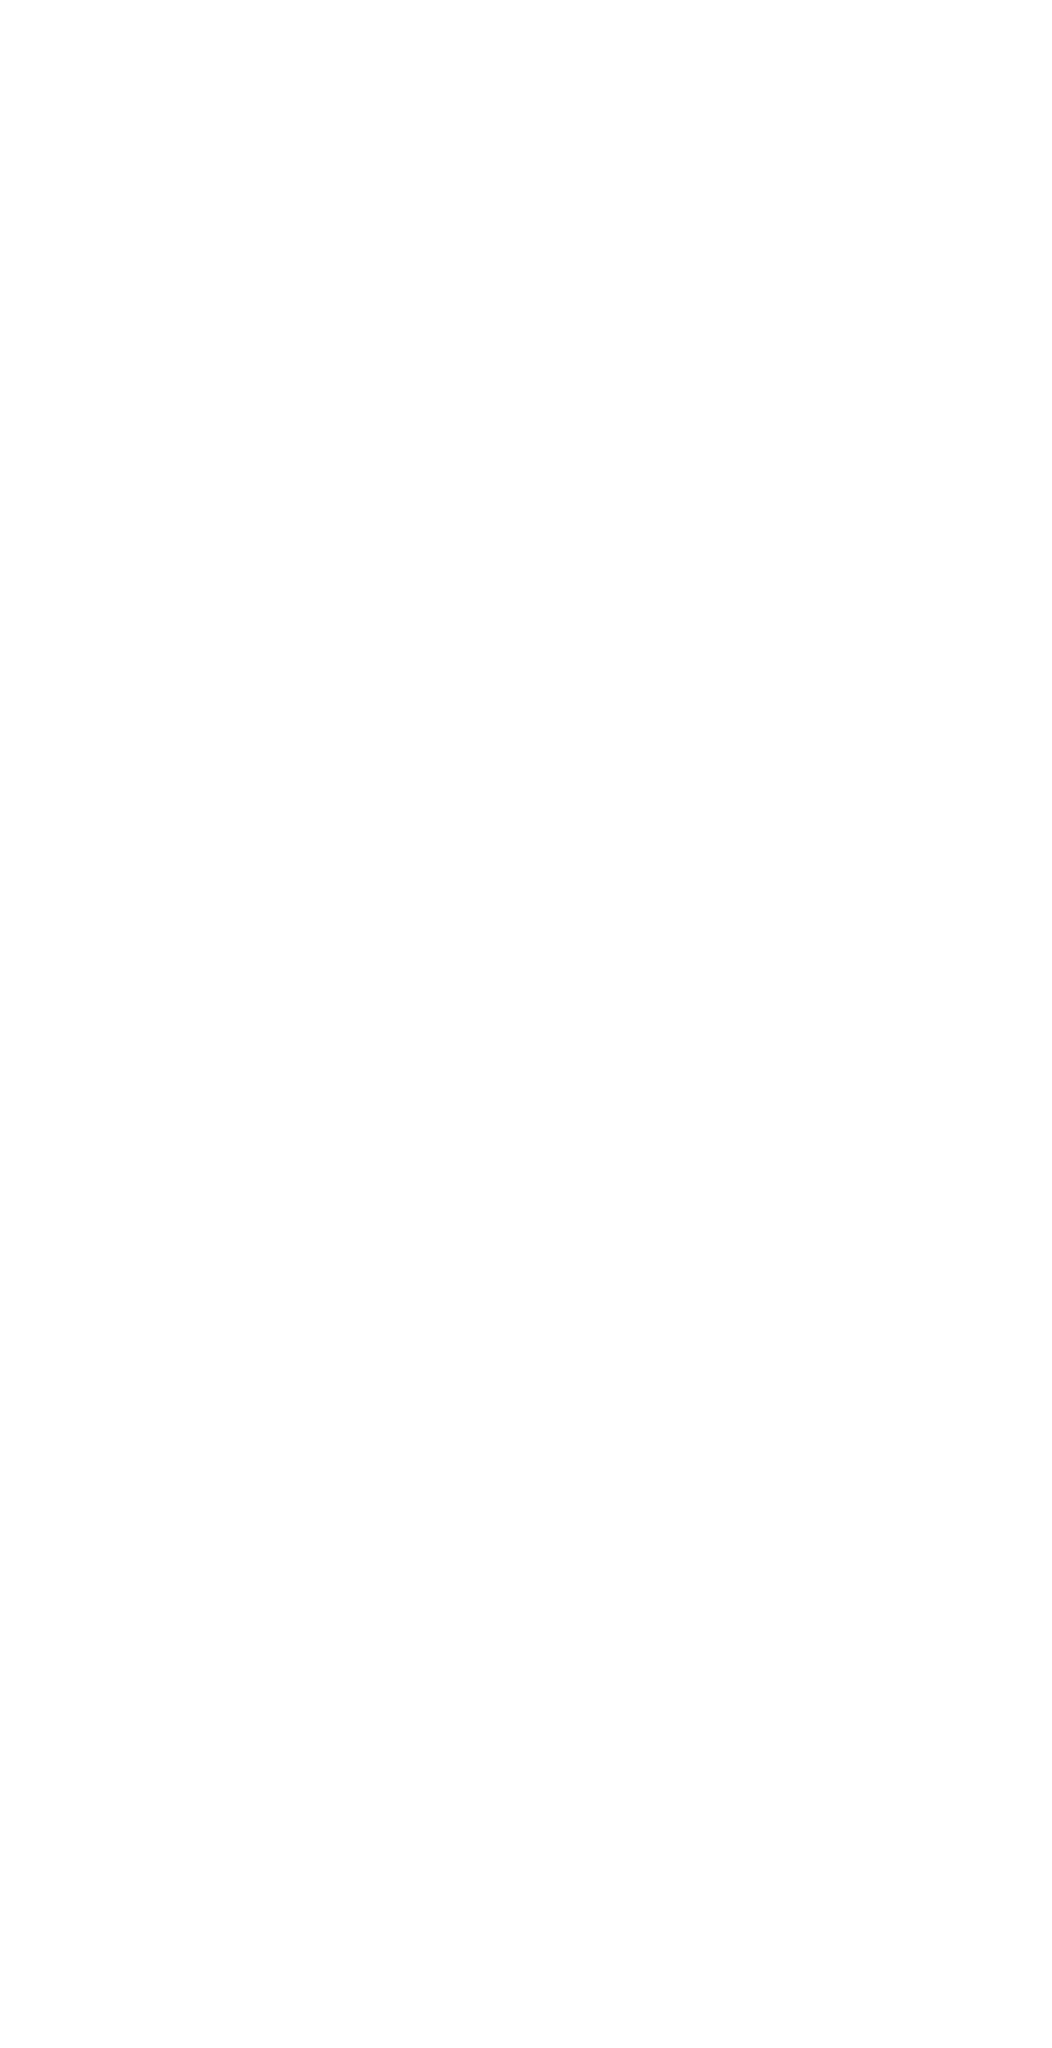

In [9]:
diag = escher_map.EscherMap(
    glycolysis.diagram,
    height='15cm',
    reaction_scale = escher_map.GaBu(minval=0, maxval=3),
    metabolite_scale = escher_map.GeGaRd(minval=-6, maxval=6),
)
reaction_data={r.id: float(v) for r, v in glycolysis.reactions.unpack(soln.x).items()}
metabolite_data={m.id: float(dmdt) for m, dmdt in glycolysis.molecules.unpack(glycolysis.s_matrix @ soln.x).items()}

SVG(diag.draw(reaction_data=reaction_data, metabolite_data=metabolite_data))

## Run glycolysis backwards (gluconeogensis)?

In [10]:
g6p = KB('Glc.D.6P')
ss_obj = fba_gd.SteadyStateObjective(glycolysis, intermediates, weight=1e6)
rbounds_obj = fba_gd.VelocityObjective(glycolysis, {rxn: (0.0, None) for rxn in glycolysis.reactions if not rxn.reversible}, weight=1e6)
prod_obj = fba_gd.ProductionObjective(glycolysis, {g6p: 1.5}, weight=10)
exclusion1 = fba_gd.ExclusionObjective(glycolysis, [KB('pfk'), KB('fbp')])
exclusion2 = fba_gd.ExclusionObjective(glycolysis, [KB('pyk'), KB('pps')])

def fn(v):
    dmdt = glycolysis.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, rbounds_obj, prod_obj, exclusion1, exclusion2])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, rando_v, jac=jacfn, tol=1e-12)
pd.Series(glycolysis.reactions.unpack(soln.x))


[gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH      -9.000000e-01
[pgk] 3PG + ATP <=> DPG + ADP                     7.500000e-01
[gpm] 2PG <=> 3PG                                 6.000000e-01
[eno] 2PG <=> H2O + PEP                          -4.500000e-01
[pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+    3.000000e-01
[pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH     -1.500000e-01
[pyk] ATP + pyr <=> ADP + H+ + PEP               -1.025590e-10
[tpi] GAP <=> DHAP                                4.500000e-01
[fba] FDP <=> GAP + DHAP                         -6.000000e-01
[pfk] ATP + F6P => ADP + FDP + H+                 1.753498e-09
[pgi] G6P <=> F6P                                -1.200000e+00
[fbp] FDP + H2O => F6P + Pi                       9.000000e-01
dtype: float64

### Doesn't work... why?
- Break into upper and lower, and run each backward

### Upper

In [11]:
glycolysis.data()

CANON:glycolysis
name: Glycolysis
shorthand: None
aka: None
description: None
xrefs: None
size: 12 reactions over 21 molecules.
reactions: 
    [gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH
    [pgk] 3PG + ATP <=> DPG + ADP
    [gpm] 2PG <=> 3PG
    [eno] 2PG <=> H2O + PEP
    [pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+
    [pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH
    [pyk] ATP + pyr <=> ADP + H+ + PEP
    [tpi] GAP <=> DHAP
    [fba] FDP <=> GAP + DHAP
    [pfk] ATP + F6P => ADP + FDP + H+
    [pgi] G6P <=> F6P
    [fbp] FDP + H2O => F6P + Pi


In [12]:
network_upper = Pathway([r for r in glycolysis.reactions if r.id in {'pgi', 'pfk', 'fbp', 'fba', 'tpi'}])
pd.DataFrame(
    network_upper.s_matrix,
    columns=network_upper.reactions.labels(),
    index=network_upper.reactants.labels())


,TPI,FBA,PFK,PGI,FBP
GAP,-1.0,1.0,0.0,0.0,0.0
DHAP,1.0,1.0,0.0,0.0,0.0
FDP,0.0,-1.0,1.0,0.0,-1.0
ATP,0.0,0.0,-1.0,0.0,0.0
F6P,0.0,0.0,-1.0,1.0,1.0
ADP,0.0,0.0,1.0,0.0,0.0
H+,0.0,0.0,1.0,0.0,0.0
G6P,0.0,0.0,0.0,-1.0,0.0
H2O,0.0,0.0,0.0,0.0,-1.0
Pi,0.0,0.0,0.0,0.0,1.0


In [13]:
ss_obj = fba_gd.SteadyStateObjective(network_upper, [KB(m_id) for m_id in ['Fru.D.6P', 'Fru.D.bis16', 'dhap']], weight=1e6)
rbounds_obj = fba_gd.VelocityObjective(network_upper, {rxn: (0.0, None) for rxn in network_upper.reactions if not rxn.reversible}, weight=1e6)
prod_obj = fba_gd.ProductionObjective(network_upper, {g6p: 1.5}, weight=10)
exclusion1 = fba_gd.ExclusionObjective(network_upper, [KB('pfk'), KB('fbp')])

def fn(v):
    dmdt = network_upper.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, rbounds_obj, prod_obj, exclusion1])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, jax.random.normal(prng, network_upper.shape[1:]), jac=jacfn, tol=1e-12)
pd.Series(network_upper.reactions.unpack(soln.x))


[tpi] GAP <=> DHAP                   1.500000e+00
[fba] FDP <=> GAP + DHAP            -1.500000e+00
[pfk] ATP + F6P => ADP + FDP + H+    9.886116e-14
[pgi] G6P <=> F6P                   -1.500000e+00
[fbp] FDP + H2O => F6P + Pi          1.500000e+00
dtype: float64

### Lower

In [14]:
network_lower = Pathway([r for r in glycolysis.reactions if r not in network_upper.reactions])
pd.DataFrame(
    network_lower.s_matrix,
    columns=network_lower.reactions.labels(),
    index=network_lower.reactants.labels())


,GAPDH,PGK,GPM,ENO,PPS,PDH,PYK
GAP,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
NAD+,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0
Pi,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
DPG,1.0,1.0,0.0,0.0,0.0,0.0,0.0
H+,1.0,0.0,0.0,0.0,2.0,0.0,1.0
NADH,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3PG,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
ATP,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0
ADP,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2PG,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0


In [15]:
gap = KB('gap')
ss_obj = fba_gd.SteadyStateObjective(network_lower, [KB(m_id) for m_id in ['dpg', '2pg', '3pg', 'pep', 'pyr']], weight=1e6)
rbounds_obj = fba_gd.VelocityObjective(network_lower, {rxn: (0.0, None) for rxn in network_lower.reactions if not rxn.reversible}, weight=1e6)
prod_obj = fba_gd.ProductionObjective(network_lower, {gap: 3.}, weight=10)
exclusion2 = fba_gd.ExclusionObjective(network_lower, [KB('pyk'), KB('pps')])


def fn(v):
    dmdt = network_lower.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, rbounds_obj, prod_obj, exclusion2])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, jax.random.normal(prng, network_lower.shape[1:]), jac=jacfn, tol=1e-12)
pd.Series(network_lower.reactions.unpack(soln.x))


[gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH      -2.571429e+00
[pgk] 3PG + ATP <=> DPG + ADP                     2.142857e+00
[gpm] 2PG <=> 3PG                                 1.714286e+00
[eno] 2PG <=> H2O + PEP                          -1.285714e+00
[pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+    8.571429e-01
[pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH     -4.285714e-01
[pyk] ATP + pyr <=> ADP + H+ + PEP               -2.501313e-14
dtype: float64

## PDH is irreveversible!
- Treat pyruvate as a boundary, not an intermediate

In [16]:
ss_obj = fba_gd.SteadyStateObjective(network_lower, [KB(m_id) for m_id in ['dpg', '2pg', '3pg', 'pep']])

def fn(v):
    dmdt = network_lower.s_matrix @ v
    return sum(jnp.sum(jnp.square(objective.residual(v, dmdt, objective.params()))) for objective in [ss_obj, rbounds_obj, prod_obj, exclusion2])

jfn = jax.jit(fn)
jacfn = jax.jit(jax.jacfwd(fn))

soln = scipy.optimize.minimize(jfn, jax.random.normal(prng, network_lower.shape[1:]), jac=jacfn, tol=1e-12)
pd.Series(network_lower.reactions.unpack(soln.x))


[gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH      -3.000000e+00
[pgk] 3PG + ATP <=> DPG + ADP                     3.000000e+00
[gpm] 2PG <=> 3PG                                 3.000000e+00
[eno] 2PG <=> H2O + PEP                          -3.000000e+00
[pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+    3.000000e+00
[pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH      2.171492e-01
[pyk] ATP + pyr <=> ADP + H+ + PEP                1.718466e-15
dtype: float64

- It works. We found the problem.
- Flux goes through PYK and not PPS. This is not biologically correct, but as constructed it is valid
    - PYK is reversible. We could make it irreversible but that is not actually correct (it is pyruvate _kinase_ after all).
    - _in vivo_, PPS would be prefered but that's for energetic reasons, which are not captured in FBA. Unless we can work that into the objective function...